In [1]:
import _init_paths

from tqdm import tqdm
import cv2
import torch
import numpy as np
import os

import pandas as pd
from detectors.detector_factory import detector_factory
from datasets.dataset_factory import get_dataset
from models.decode import ddd_decode,fish_decode
from utils.debugger import Debugger
from opts import opts

from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation

from numpy.linalg import inv
from sklearn.metrics.pairwise import cosine_similarity
import imgaug.augmenters as iaa

In [2]:
from shutil import rmtree

In [3]:
from torchvision.ops import box_iou
from munkres import Munkres, print_matrix

In [4]:
def read_calib(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        P2 = np.array(lines[2].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)
        
    return P2

def get_corners(data,rx=0,ry=0,rz=0,x=None,y=None,z=None):
    
    x = data['x'] if x == None else x
    y = data['y'] if y == None else y
    z = data['z'] if z == None else z
#     Rotation matrix
#     Rc = Rotation.from_euler('xyz', [0,90,0], degrees=True).as_matrix()
#     Rc = Rotation.from_euler('xyz', [0,-90,0], degrees=True).as_matrix()
#     Rc = Rotation.from_euler('zxy', [0,0,-90], degrees=True).as_matrix()
    R = Rotation.from_euler('zxy', [rz,rx,ry], degrees=False).as_matrix()
    
#     R = roty(data['yaw'])
    l = float(data['l'])
    w = float(data['w'])
    h = float(data['h'])
    
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
#     y_corners = [0,0,0,0,h,h,h,h]
    y_corners = [h/2,h/2,h/2,h/2,-h/2,-h/2,-h/2,-h/2]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]
    
    corners = np.dot(R,np.vstack([x_corners, y_corners, z_corners]))
#     corners = np.dot(Rc,np.vstack([x_corners, y_corners, z_corners]))
#     corners = np.dot(R,corners)

#     translate from origin 
    corners[0,:] = corners[0,:] + x
    corners[1,:] = corners[1,:] + y
    corners[2,:] = corners[2,:] + z
#     corners = np.dot(R,corners)
    return corners

def project_3d(P,corner):
    conn = np.concatenate((corner.T, np.ones((8, 1))), axis=1)
    corners_img_before = np.matmul(conn, P.T)
    corners_img = corners_img_before[:, :2] / corners_img_before[:, 2][:, None]
    
    return corners_img

def random_color():
    r = random.randint(0, 255)
#     g = random.randint(0, 255)
#     b = random.randint(0, 255)
    rand_color = (255, 0, 0)
    return rand_color

def plot_img(plot,pts):
    
    color = random_color()
    color_red = [0,0,255]
    # TOP SIDE EFGH
    plot = draw_line(plot,pts[4],pts[5],color=color)
    plot = draw_line(plot,pts[5],pts[6],color=color)
    plot = draw_line(plot,pts[6],pts[7],color=color)
    plot = draw_line(plot,pts[7],pts[4],color=color)

    # BOT SIDE ABCD
#     plot = draw_line(plot,pts[0],pts[1],color=(255,0,0))
#     plot = draw_line(plot,pts[1],pts[2],color=(255,0,0))
#     plot = draw_line(plot,pts[2],pts[3],color=(255,0,0))
#     plot = draw_line(plot,pts[3],pts[0],color=(255,0,0))
    
    plot = draw_line(plot,pts[0],pts[1],color=color)
    plot = draw_line(plot,pts[1],pts[2],color=color)
    plot = draw_line(plot,pts[2],pts[3],color=color)
    plot = draw_line(plot,pts[3],pts[0],color=color)

    # TIANG AE BF CG DH
    plot = draw_line(plot,pts[0],pts[4],color=color)
    plot = draw_line(plot,pts[1],pts[5],color=color)
    plot = draw_line(plot,pts[2],pts[6],color=color)
    plot = draw_line(plot,pts[3],pts[7],color=color)
    
#     plot = draw_line(plot,pts[0],pts[5],color=(255,0,0))
#     plot = draw_line(plot,pts[4],pts[1],color=(255,0,0))

    # front
#     1,2,6,5,1
    return plot

def draw_line(img,ptA,ptB,color=(255, 0, 0)):
    start_point = (int(ptA[0]),int(ptA[1]))
    end_point = (int(ptB[0]),int(ptB[1]))
    thickness = 1
    
    img = cv2.line(img, start_point, end_point, color, thickness)
    return img

def draw_rect(img,data,color=(0, 255, 0)):
    x0,y0 = int(data['xmin']),int(data['ymin'])
    x1,y1 = int(data['xmax']),int(data['ymax'])
    
    img = cv2.rectangle(img,(x0,y0),(x1,y1), color, 2)
    return img

def roty(t):
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, 0, s], 
                     [0, 1, 0], 
                     [-s, 0, c]])

def calc_theta_ray(width, xmin,xmax, proj_matrix,is_y=False):
#     if is_y:
#         temp = xmin
#         xmin = 512-xmax
#         xmax = 512-temp
    
    fovx = 2 * np.arctan(width / (2 * proj_matrix[0][0]))
    center = xmin + abs(xmax-xmin)/2
    
    center = width - center if is_y else center
    
    dx = center - (width / 2)

    mult = 1
    if dx < 0:
        mult = -1
    dx = abs(dx)
    angle = np.arctan( (2*dx*np.tan(fovx/2)) / width )
    angle = angle * mult

    angle = fovx/2 - angle
    return angle

def get_theta(width,xmin,xmax,P,is_y=False):
    center = xmin + abs(xmax-xmin)/2
    F = P[0][0]
    dx = center - (width/2)
    dx = width - dx if is_y else dx
    theta = np.arctan(dx/F)
    
    theta = theta + np.pi/2 if is_y else theta
    return theta

def calc_theta_ray(width, xmin,xmax, proj_matrix,is_y=False):
    
    fovx = 2 * np.arctan(width / (2 * proj_matrix[0][0]))
    center = xmin + abs(xmax-xmin)/2
    
    center = width - center if is_y else center
    
    dx = center - (width / 2)

    mult = 1
    if dx < 0:
        mult = -1
    dx = abs(dx)
    angle = np.arctan( (2*dx*np.tan(fovx/2)) / width )
    angle = angle * mult

    angle = fovx/2 - angle
    return angle

def calc_theta_ray_center(width, center, proj_matrix,is_y=False):
    fovx = 2 * np.arctan(width / (2 * proj_matrix[0][0]))
    
    center = width - center if is_y else center
    
    dx = center - (width / 2)

    mult = 1
    if dx < 0:
        mult = -1
    dx = abs(dx)
    angle = np.arctan( (2*dx*np.tan(fovx/2)) / width )
    angle = angle * mult

    angle = fovx/2 - angle
    return angle

def get_ry(img_size,t):
    return (calc_theta_ray_center(img_size,t['cx'],P) + t['alphax'])

def get_rx(img_size,t):
    return -(calc_theta_ray_center(img_size,t['cy'],P,is_y=True) + t['alphay']) * -1

def get_xy(ann,center,P,c=0):
    
    center = np.array(center).reshape((1,2))
    depth = np.array(ann['z']).reshape(1,1)

    return imagetocamera(center,depth,P)

def imagetocamera(points, depth, projection):
    """
    points: (N, 2), N points on X-Y image plane
    depths: (N,), N depth values for points
    projection: (3, 4), projection matrix
    corners: (N, 3), N points on X(right)-Y(down)-Z(front) camera coordinate
    """
    assert points.shape[1] == 2, "Shape ({}) not fit".format(points.shape)

    corners = np.hstack([points, np.ones(
        (points.shape[0], 1))]).dot(inv(projection[:, 0:3]).T)
    assert np.allclose(corners[:, 2], 1)
    corners *= depth.reshape(-1, 1)

    return list(corners[0])

In [5]:
def get_iou(gt,pred,prev_shape,iou_thresh=0.5):
    ground_truth_bbox = torch.tensor(gt, dtype=torch.float)
    prediction_bbox = torch.tensor(pred, dtype=torch.float)

    # Get iou.
    iou = box_iou(ground_truth_bbox, prediction_bbox)
    iou = iou.numpy()
    
    results = np.empty(iou.shape[0], dtype=bool)
    for i in range(iou.shape[0]):
        max_value = np.max(iou[i])
        results[i] = max_value > iou_thresh
    
    true_indices = np.where(results)[0]
    false_indices = np.where(~results)[0]
    
    diff = len(true_indices) - prev_shape
    if diff > 0:
#         print('before',len(true_indices), prev_shape,diff)
        for i in range(diff):
            min_idx = np.argmin(np.max(iou[true_indices],axis=1))
            false_indices = np.append(false_indices,true_indices[min_idx])
            true_indices = np.delete(true_indices, min_idx)
#             print('after',len(true_indices), prev_shape)
            
    false_indices = sorted(false_indices)
    true_indices = sorted(true_indices)
    
    
    return true_indices,false_indices

In [6]:
seq = iaa.Sequential([
    iaa.CLAHE(clip_limit=(3)),
    ]
    )

In [7]:
# big with sim2real -> big_sim2real_all
# salmon with no aug -> salmon_finetune
# salmon_base

In [8]:
emb_dict = dict()
ids_frame_0 = dict()
ids_frame_1 = dict()

In [9]:
# tracking_test
frame_num = 1

In [10]:
MODEL_PATH = '../models/red_orbitting_3cam_output_3.pth'
# MODEL_PATH = '../exp/fish/reid_val/model_last.pth'
TASK = 'fish'
DATASET = 'fish_sim'
IMG_PATH = '../data/kitti/images/trainval/'+str(frame_num).zfill(6)+'.jpg'

In [11]:
Dataset = get_dataset(DATASET, TASK)

# config init
opt = opts().init('{} --load_model {}'.format(TASK, MODEL_PATH).split(' '))
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

detector = detector_factory[opt.task](opt)
debugger = Debugger(dataset=detector.opt.dataset, ipynb=(detector.opt.debug==3),
                        theme=detector.opt.debugger_theme)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /home/alfin/Documents/deep_learning/production/centernet_3d_fish/src/lib/../../exp/fish/default
heads {'hm': 1, 'reg': 2, 'dep': 1, 'dim': 3, 'rot': 2}
heads {'hm': 1, 'reg': 2, 'dep': 1, 'dim': 3, 'rot': 2}
Creating model...
loaded ../models/red_orbitting_3cam_output_3.pth, epoch 67


In [12]:
img_ori = cv2.imread(IMG_PATH)
img_ori = cv2.resize(img_ori,(512,512))

crop = cv2.cvtColor(img_ori.copy(),cv2.COLOR_BGR2RGB)
crop = seq(image=crop)
img_ori = cv2.cvtColor(crop.copy(),cv2.COLOR_RGB2BGR)

img = img_ori.copy()

img_input = detector.pre_process(img)
img_input = img_input.to(detector.opt.device)

In [13]:
# Manual

In [14]:
torch.no_grad()
torch.cuda.synchronize()

In [15]:
output = detector.model(img_input)[-1]

In [16]:
output.keys()

dict_keys(['hm', 'reg', 'dep', 'dim', 'rot'])

In [17]:
output['hm'] = output['hm'].sigmoid_()
output['dep'] = 1. / (output['dep'].sigmoid() + 1e-6) - 1.
reg = output['reg']
torch.cuda.synchronize()

output.keys()

dict_keys(['hm', 'reg', 'dep', 'dim', 'rot'])

In [18]:
for key in output.keys():
    print(key,output[key].shape)

hm torch.Size([1, 1, 128, 128])
reg torch.Size([1, 2, 128, 128])
dep torch.Size([1, 1, 128, 128])
dim torch.Size([1, 3, 128, 128])
rot torch.Size([1, 2, 128, 128])


In [19]:
hms = key,output['hm'].detach().cpu().numpy()
hms = hms[1][0]
hms.shape

(1, 128, 128)

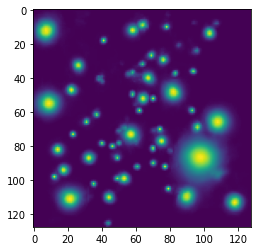

In [20]:
plt.imshow((np.moveaxis(hms, 0, -1)*255).astype(int))

In [21]:
# dets = fish_decode(output['hm'],output['reg'],output['dep'],output['dim'],output['rot'],output['wh'],output['reid'],K=detector.opt.K)
dets = fish_decode(output['hm'],output['reg'],output['dep'],output['dim'],output['rot'],K=detector.opt.K)

In [22]:
len(dets)

300

In [23]:
len(dets[1])

7

In [24]:
down_ratio = debugger.down_ratio
img = img_ori.copy()

if frame_num in emb_dict:
    emb_dict[frame_num] = []

for det in dets:
    scores = det['conf']
    class_name = int(det['class'])
    
    cx = int(det['cx'] * down_ratio)
    cy = int(det['cy'] * down_ratio)
    
#     w = int(det['wh'][0] * down_ratio)
#     h = int(det['wh'][1] * down_ratio)
    
#     xmin = cx - w//2
#     xmax = cx + w//2
#     ymin = cy - h//2
#     ymax = cy + h//2
    
#     reid = det['reid'].reshape((1,-1))
    if scores > 0.8:
            
#         if frame_num in emb_dict:
#             emb_dict[frame_num].append(reid)
#         else:
#             emb_dict[frame_num] = []
#         print(cx,cy,xmin,ymin,xmax,ymax,class_name,scores)
#         img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 2)
        img = cv2.circle(img, (cx,cy), radius=3, color=(0, 0, 255), thickness=-1)

In [25]:
img_copy = img.copy()
img_copy = cv2.blur(img_copy, (12, 12))

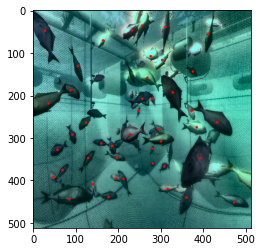

In [26]:
plt.imshow(img[...,::-1])
plt.show()

In [27]:
['2023_0110_BURI03','madai_easy_pad_512_last','Madai03','2023_0110_BURI01']
# testiing_video _> salmon
# 2021_1105_L02_Sq_R_d2_E_150_Madai10_1245_HD

['2023_0110_BURI03', 'madai_easy_pad_512_last', 'Madai03', '2023_0110_BURI01']

In [28]:
seq = iaa.Sequential([
    iaa.CLAHE(clip_limit=(3)),
    ]
    )

In [29]:
m = Munkres()
max_id = 0
img_dirs = '../data/kitti/images/trainval'
img_dirs = '/home/alfin/Documents/deep_learning/fish_conversion/data/general_eval/KITTI/detection/training/image_2/'
img_dirs = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/'

img_dirs = os.path.join(img_dirs,'output_3_pad')

CALIB_DIR = '/home/alfin/Documents/deep_learning/production/centernet_3d_fish/data'
calib_path = os.path.join(CALIB_DIR,'000000.txt')

if os.path.exists(os.path.join(img_dirs,'..','label_inference')):
    rmtree(os.path.join(img_dirs,'..','label_inference'))

os.makedirs(os.path.join(img_dirs,'..','label_inference'))
imgs = sorted(os.listdir(img_dirs))[:300]

down_ratio = debugger.down_ratio

img_input_size = (512,512)

for idx,img_path in enumerate(tqdm(imgs)):

    img_ori = cv2.imread(os.path.join(img_dirs,img_path))
    img_ori = cv2.resize(img_ori,(512,512))
    P = read_calib(calib_path)

    img = img_ori.copy()
    
    img_input = detector.pre_process(img)
    img_input = img_input.to(detector.opt.device)

    torch.no_grad()
    torch.cuda.synchronize()

    output = detector.model(img_input)[-1]

    output['hm'] = output['hm'].sigmoid_()
    output['dep'] = 1. / (output['dep'].sigmoid() + 1e-6) - 1.
    torch.cuda.synchronize()

    dets = fish_decode(output['hm'],output['reg'],output['dep'],output['dim'],output['rot'],K=detector.opt.K)
    out = list()
    
    tracklets = []
    for det in dets:
        scores = det['conf'][0]
        class_name = int(det['class'])

        cx = int(det['cx'] * down_ratio)
        cy = int(det['cy'] * down_ratio)
        
        dim = list(det['dim'])
        depth = det['dep'][0]
        rot = list(np.radians(det['rot']))

#         w = int(det['wh'][0] * down_ratio)
#         h = int(det['wh'][1] * down_ratio)

#         xmin = cx - w//2
#         xmax = cx + w//2
#         ymin = cy - h//2
#         ymax = cy + h//2
        
#         bbox = [xmin,ymin,xmax,ymax]
        
        if scores > 0.1:
            
            merged = list()
            merged += dim
            
            merged.append(depth)
            
            merged += rot
            
            merged.append(scores)
            merged.append(int(idx))
            merged.append(cx)
            merged.append(cy)
            
            merged_label = pd.DataFrame([merged],columns=['h','l','w','z','alphax','alphay','conf','idx','cx','cy'])
            label = merged_label.iloc[0]
            center = (cx,cy)
            x,y,z = get_xy(label,center,P)

            ry = get_ry(img_input_size[0],label)
            rx = get_rx(img_input_size[1],label) 
            rz = 0

            cor = get_corners(label,rx,ry,rz,x=x,y=y,z=z)
            pts = project_3d(P,cor)
            
            xs = [int(x[0]) for x in pts]
            ys = [int(x[1]) for x in pts]
            
            xmin = min(xs)
            ymin = min(ys)
            xmax = max(xs)
            ymax = max(ys)
            
            merged.append(xmin)
            merged.append(ymin)
            merged.append(xmax)
            merged.append(ymax)
            merged.append(0)
            out.append(merged)

    
    df = pd.DataFrame(out,columns=['h','w','l','z','alphax','alphay','conf','idx','cx','cy','xmin','ymin','xmax','ymax','id'])
    if len(df)==0:
        print(idx)
    df.to_csv(os.path.join(img_dirs,'..','label_inference',os.path.splitext(os.path.basename(img_path))[0]+'.txt'),header=False,sep=' ',index=False)

100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 21.65it/s]


In [30]:
P

array([[281.31866,   0.     , 256.     ,   0.     ],
       [  0.     , 281.31866, 256.     ,   0.     ],
       [  0.     ,   0.     ,   1.     ,   0.     ]], dtype=float32)

In [32]:
np.array([[281.31866,   0.     , 256.     ,   0.     ],
       [  0.     , 281.31866, 256.     ,   0.     ],
       [  0.     ,   0.     ,   1.     ,   0.     ]], dtype=np.float32)

array([[281.31866,   0.     , 256.     ,   0.     ],
       [  0.     , 281.31866, 256.     ,   0.     ],
       [  0.     ,   0.     ,   1.     ,   0.     ]], dtype=float32)

In [36]:
m = Munkres()
max_id = 0
img_dirs = '../data/kitti/images/trainval'
img_dirs = '/home/alfin/Documents/deep_learning/fish_conversion/data/general_eval/KITTI/detection/training/image_2/'
img_dirs = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/'

img_dirs = os.path.join(img_dirs,'output_3')

CALIB_DIR = '/home/alfin/Documents/deep_learning/production/centernet_3d_fish/data'
calib_path = os.path.join(CALIB_DIR,'000000.txt')
# 
if os.path.exists(os.path.join(img_dirs,'..','label_inference')):
    rmtree(os.path.join(img_dirs,'..','label_inference'))

os.makedirs(os.path.join(img_dirs,'..','label_inference'))
imgs = sorted(os.listdir(img_dirs))[:300]

down_ratio = debugger.down_ratio

img_input_size = (512,512)
states = dict()
# print(imgs)
for idx,img_path in enumerate(tqdm(imgs)):
    
#     print('frame',idx)
    s0 = dict() if idx == 0 else states[idx-1]
    s1 = dict()
    
#     print(idx,s0.keys())
    img_ori = cv2.imread(os.path.join(img_dirs,img_path))
    img_ori = cv2.resize(img_ori,(512,512))
    P = read_calib(calib_path)
#     crop = cv2.cvtColor(img_ori.copy(),cv2.COLOR_BGR2RGB)
#     crop = seq(image=crop)
#     img_ori = cv2.cvtColor(crop.copy(),cv2.COLOR_RGB2BGR)

    img = img_ori.copy()
#     img = cv2.blur(img, (3, 3))
    
    img_input = detector.pre_process(img)
    img_input = img_input.to(detector.opt.device)

    torch.no_grad()
    torch.cuda.synchronize()

    output = detector.model(img_input)[-1]

    output['hm'] = output['hm'].sigmoid_()
    output['dep'] = 1. / (output['dep'].sigmoid() + 1e-6) - 1.
    torch.cuda.synchronize()

    dets = fish_decode(output['hm'],output['reg'],output['dep'],output['dim'],output['rot'],output['reid'],K=detector.opt.K)
    out = list()
    
    tracklets = []
    for det in dets:
        scores = det['conf'][0]
        class_name = int(det['class'])

        cx = int(det['cx'] * down_ratio)
        cy = int(det['cy'] * down_ratio)
        
        dim = list(det['dim'])
        depth = det['dep'][0]
        
#         rot = list(det['rot'])
#         rot = Rotation.from_quat(rot).as_euler('xyz')
#         rot = list(rot[:2])
        rot = list(np.radians(det['rot']))
        reid = det['reid'].reshape((1,-1))

#         w = int(det['wh'][0] * down_ratio)
#         h = int(det['wh'][1] * down_ratio)
        
        w = 0
        h = 0
        
        xmin = cx - w//2
        xmax = cx + w//2
        ymin = cy - h//2
        ymax = cy + h//2
        
        bbox = [xmin,ymin,xmax,ymax]
        tracklet = {'reid' : reid,
                    'bbox' : bbox}
        
        if scores > 0.3:
            
            if idx == 0:
                max_id = max(s0.keys()) if len(s0.keys())>0 else 0
                s0[max_id + 1] = tracklet
                max_id = max(list(s0.keys()))

            tracklets.append(tracklet)
            
            merged = list()
            merged += dim
            
            merged.append(depth)
            
            merged += rot
            
            merged.append(scores)
            merged.append(int(idx))
            merged.append(cx)
            merged.append(cy)
            
            merged_label = pd.DataFrame([merged],columns=['h','w','l','z','alphax','alphay','conf','idx','cx','cy'])
            label = merged_label.iloc[0]
            center = (cx,cy)
            x,y,z = get_xy(label,center,P)

            ry = get_ry(img_input_size[0],label)
            rx = get_rx(img_input_size[1],label) 
            rz = 0

            cor = get_corners(label,rx,ry,rz,x=x,y=y,z=z)
            pts = project_3d(P,cor)
            
            xs = [int(x[0]) for x in pts]
            ys = [int(x[1]) for x in pts]
            
            xmin = min(xs)
            ymin = min(ys)
            xmax = max(xs)
            ymax = max(ys)
            
            merged.append(xmin)
            merged.append(ymin)
            merged.append(xmax)
            merged.append(ymax)
            merged.append(0)
            out.append(merged)
    
    if idx == 0 :
        s1 = s0
    
    reid_0 = np.array([s0[x]['reid'] for x in list(s0.keys())[:]]).squeeze(axis=1)
    reid_1 = np.array([x['reid'] for x in tracklets]).squeeze(axis=1)
    
    bbox_0 = np.array([s0[x]['bbox'] for x in list(s0.keys())[:]])
    bbox_1 = np.array([x['bbox'] for x in tracklets])
    
    box_pos,box_neg = get_iou(bbox_1,bbox_0,len(reid_0),iou_thresh=0.1)
    
    reid_1_pos = reid_1[box_pos]
    reid_1_neg = reid_1[box_neg]
    
    print(reid_1_pos.shape,reid_0.shape)
    try:
        cos = cosine_similarity(reid_1_pos,reid_0)
    except Exception as e:
        print(e)
        print(print('cos:',cos.shape,'reid 0:',reid_0.shape,'reid 1 pos:',reid_1_pos.shape))
        print(box_pos,box_neg)
        
    cos = (1.0-cos)
    print(cos)
    try:
        indexes = m.compute(cos)
    except:
        print('cos:',cos.shape,'reid 0:',reid_0.shape,'reid 1 pos:',reid_1_pos.shape)
        
    for row, column in indexes:
        value = cos[row][column]
    
    for enum,pos_idx in enumerate(box_pos):
        row, column = indexes[enum]
        
        fish_id = list(s0.keys())[column]
        out[pos_idx].append(fish_id)
        if idx > 0:
            s1[fish_id] = { 'reid' : reid_1[pos_idx].reshape((1,-1)),
                            'bbox' : bbox_1[pos_idx]
                            }
    
    for enum,neg_idx in enumerate(box_neg):
        fish_id = max_id + 1
        max_id = fish_id
        out[neg_idx].append(fish_id)
        
        if idx > 0:
            s1[fish_id] = { 'reid' : reid_1[neg_idx].reshape((1,-1)),
                            'bbox' : bbox_1[neg_idx]
                            }
    
    states[idx] = s1
    
    df = pd.DataFrame(out,columns=['h','w','l','z','alphax','alphay','conf','idx','cx','cy','xmin','ymin','xmax','ymax','id'])
    if len(df)==0:
        print(idx)
    df.to_csv(os.path.join(img_dirs,'..','label_inference',os.path.splitext(os.path.basename(img_path))[0]+'.txt'),header=False,sep=' ',index=False)

 71%|██████████████████████████████████████████████████▏                    | 212/300 [00:06<00:02, 32.01it/s]

206


100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 32.21it/s]


In [74]:
df

,h,w,l,z,alphax,alphay,conf,idx,cx,cy,xmin,ymin,xmax,ymax,id
0,0.144823,0.065895,0.332498,1.157228,0.214040,5.744151,0.991570,299,224,143,200,103,252,172,0
1,0.151973,0.069223,0.348819,1.093937,1.623867,5.252581,0.973411,299,357,267,335,244,374,293,0
2,0.153597,0.069972,0.352853,1.415655,1.662991,4.729012,0.964327,299,320,339,291,316,344,366,0
3,0.133950,0.061091,0.307553,1.787999,5.283892,5.579156,0.956417,299,164,237,137,225,189,247,0
4,0.147756,0.067021,0.339061,0.770727,1.525429,5.765335,0.954153,299,425,187,391,132,478,221,0
5,0.152067,0.069207,0.349109,1.089057,1.504192,5.262859,0.930886,299,329,223,301,192,350,246,0
6,0.149350,0.067838,0.342891,1.566285,1.848637,4.600142,0.919595,299,324,316,294,299,351,335,0
7,0.154706,0.070251,0.355632,2.221949,5.761298,5.826317,0.844476,299,164,160,144,144,184,174,0
8,0.148493,0.067455,0.340986,1.206600,1.225117,5.489430,0.803297,299,344,175,324,139,370,201,0
9,0.144146,0.065759,0.330515,1.879818,1.308083,5.034260,0.785639,299,388,268,369,256,410,282,0


In [31]:
for i in range(len(states)-1):
    s0 = states[i]
    s1 = states[i+1]
    
    reid_0 = np.array([s0[x]['reid'] for x in list(s0.keys())[:]]).squeeze(axis=1)
    reid_1 = np.array([s1[x]['reid'] for x in list(s1.keys())[:]]).squeeze(axis=1)
    
    bbox_0 = np.array([s0[x]['bbox'] for x in list(s0.keys())[:]])
    bbox_1 = np.array([s1[x]['bbox'] for x in list(s1.keys())[:]])
    
    box_pos,box_neg = get_iou(bbox_1,bbox_0,len(reid_0),iou_thresh=0.1)
    
    cos = cosine_similarity(reid_1_pos,reid_0)
    indexes = m.compute(cos)

In [ ]:
for idx,val in indexes:
    print(cos[idx,val])